# HC model for whole blood applied to unhealthy

- Applying the 56 CpG site HC model to Alzheimer's and Parkinson's patients
- The 56 common sites were found in unhealthy_wholeblood_top_100xgboost notebook and saved to the file being read in called whole_blood_shared_healthy_unhealthy
- The unhealthy data was processed in unhealthy_wholeblood_top_100xgboost.ipynb and saved to park_blood_top100_xgboost.csv for Parkinson's patients and alz_blood_top100_xgboost.csv for Alzheimer's patients



In [1]:
import _pickle as cPickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

### Reading in data

In [5]:
parkinsons_df=pd.read_csv('park_blood_top100_xgboost.csv',index_col=0)  

In [6]:
alzheimers_df=pd.read_csv('alz_blood_top100_xgboost.csv',index_col=0)  

In [7]:
with open(r"healthy_ids_from_unhealthy", "rb") as input_file:
    healthy_ids = cPickle.load(input_file)

In [8]:
with open(r"whole_blood_shared_healthy_unhealthy", "rb") as input_file:
    shared_whole_blood = cPickle.load(input_file)

### Reading in models

In [9]:
mod_56_whole_blood = pd.read_pickle(r'mod_56_whole_blood')

In [10]:
mod_lasso_56_whole_blood = pd.read_pickle(r'mod_lasso_56_whole_blood')

In [11]:
mod_ridge_56_whole_blood = pd.read_pickle(r'mod_ridge_56_whole_blood')

In [12]:
XG_56_whole_blood = pd.read_pickle(r'XG_56_whole_blood')


### Re-ordering columns

- The CpG sites need to be in the order they are in the HC dataset: this order is saved to whole_blood_shared_hc_order

In [13]:
with open(r"whole_blood_shared_hc_order", "rb") as input_file:
    whole_blood_order = cPickle.load(input_file)

In [14]:
#reordering alzheimer's columns
alzheimers_df = alzheimers_df[['AGE']+whole_blood_order]
alzheimers_df

,AGE,cg16867657,cg04875128,cg07553761,cg00292135,cg09809672,cg04208403,cg22454769,cg06639320,cg19344626,...,cg26614073,cg14692377,cg18343474,cg26113593,cg00535618,cg04503319,cg05308819,cg05093315,cg07181952,cg22193924
GSM1069225,81.0,0.772,0.364,0.391,0.147,0.431,0.545,0.655,0.530,0.631,...,0.436,0.257,0.144,0.755,0.712,0.502,0.491,0.660,0.617,0.830
GSM1069226,88.0,0.778,0.409,0.367,0.158,0.356,0.540,0.705,0.606,0.515,...,0.419,0.193,0.156,0.821,0.717,0.466,0.422,0.590,0.612,0.742
GSM1069227,91.0,0.839,0.429,0.329,0.174,0.414,0.547,0.639,0.538,0.347,...,0.291,0.228,0.154,0.807,0.671,0.537,0.461,0.673,0.635,0.847
GSM1069228,87.0,0.773,0.367,0.343,0.211,0.502,0.547,0.684,0.559,0.713,...,0.482,0.260,0.143,0.813,0.710,0.572,0.484,0.613,0.678,0.814
GSM1069229,89.0,0.822,0.325,0.392,0.144,0.287,0.428,0.667,0.587,0.256,...,0.284,0.227,0.327,0.754,0.738,0.367,0.402,0.481,0.540,0.816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1870611,75.9,0.695,0.139,0.311,0.149,0.337,0.484,0.552,0.513,0.607,...,0.394,0.151,0.140,0.769,0.727,0.556,0.437,0.621,0.610,0.814
GSM3035793,80.0,0.670,0.319,0.350,0.139,0.400,0.535,0.701,0.549,0.592,...,0.409,0.217,0.193,0.706,0.671,0.466,0.443,0.565,0.590,0.700
GSM1870291,75.9,0.695,0.139,0.311,0.149,0.337,0.484,0.552,0.513,0.607,...,0.394,0.151,0.140,0.769,0.727,0.556,0.437,0.621,0.610,0.814
GSM1299778,70.0,0.729,0.233,0.383,0.125,0.356,0.566,0.607,0.527,0.479,...,0.409,0.174,0.099,0.750,0.756,0.530,0.506,0.599,0.671,0.787


In [17]:
alzheimers_df_ids=list(alzheimers_df.index)
for i in alzheimers_df_ids:
    if i in healthy_ids:
        alzheimers_df=alzheimers_df.drop([i], axis=0)

In [18]:
alzheimers_df

,AGE,cg16867657,cg04875128,cg07553761,cg00292135,cg09809672,cg04208403,cg22454769,cg06639320,cg19344626,...,cg26614073,cg14692377,cg18343474,cg26113593,cg00535618,cg04503319,cg05308819,cg05093315,cg07181952,cg22193924
GSM1069225,81.0,0.772,0.364,0.391,0.147,0.431,0.545,0.655,0.530,0.631,...,0.436,0.257,0.144,0.755,0.712,0.502,0.491,0.660,0.617,0.830
GSM1069226,88.0,0.778,0.409,0.367,0.158,0.356,0.540,0.705,0.606,0.515,...,0.419,0.193,0.156,0.821,0.717,0.466,0.422,0.590,0.612,0.742
GSM1069227,91.0,0.839,0.429,0.329,0.174,0.414,0.547,0.639,0.538,0.347,...,0.291,0.228,0.154,0.807,0.671,0.537,0.461,0.673,0.635,0.847
GSM1069228,87.0,0.773,0.367,0.343,0.211,0.502,0.547,0.684,0.559,0.713,...,0.482,0.260,0.143,0.813,0.710,0.572,0.484,0.613,0.678,0.814
GSM1069229,89.0,0.822,0.325,0.392,0.144,0.287,0.428,0.667,0.587,0.256,...,0.284,0.227,0.327,0.754,0.738,0.367,0.402,0.481,0.540,0.816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1443699,88.0,0.710,0.381,0.337,0.147,0.355,0.507,0.560,0.504,0.579,...,0.371,0.177,0.162,0.764,0.733,0.590,0.421,0.604,0.623,0.767
GSM1443711,74.0,0.698,0.317,0.291,0.238,0.397,0.488,0.687,0.513,0.697,...,0.355,0.134,0.160,0.788,0.743,0.580,0.484,0.636,0.697,0.794
GSM1443721,74.0,0.692,0.364,0.346,0.104,0.458,0.497,0.605,0.526,0.630,...,0.418,0.182,0.227,0.780,0.751,0.534,0.482,0.557,0.613,0.804
GSM1443736,89.0,0.754,0.433,0.257,0.192,0.324,0.418,0.597,0.536,0.598,...,0.409,0.312,0.101,0.769,0.779,0.348,0.483,0.568,0.565,0.791


In [19]:
#reordering parkinsons's columns
parkinsons_df = parkinsons_df[['AGE']+whole_blood_order]
parkinsons_df

,AGE,cg16867657,cg04875128,cg07553761,cg00292135,cg09809672,cg04208403,cg22454769,cg06639320,cg19344626,...,cg26614073,cg14692377,cg18343474,cg26113593,cg00535618,cg04503319,cg05308819,cg05093315,cg07181952,cg22193924
GSM3035963,78.0,0.744,0.431,0.354,0.066,0.412,0.636,0.702,0.589,0.715,...,0.394,0.168,0.089,0.749,0.680,0.405,0.389,0.514,0.624,0.742
GSM3035809,78.0,0.762,0.335,0.309,0.130,0.334,0.515,0.606,0.532,0.734,...,0.372,0.172,0.202,0.784,0.743,0.541,0.441,0.613,0.696,0.762
GSM3035847,75.0,0.741,0.226,0.380,0.105,0.398,0.473,0.512,0.455,0.516,...,0.435,0.171,0.189,0.794,0.737,0.445,0.411,0.581,0.673,0.816
GSM1870906,71.4,0.770,0.318,0.345,0.129,0.414,0.532,0.717,0.576,0.726,...,0.417,0.144,0.194,0.778,0.723,0.436,0.466,0.643,0.665,0.728
GSM1871363,76.2,0.740,0.405,0.347,0.191,0.356,0.525,0.692,0.617,0.615,...,0.500,0.183,0.159,0.753,0.745,0.597,0.511,0.579,0.626,0.741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1506296,68.0,0.727,0.301,0.294,0.156,0.475,0.504,0.644,0.505,0.568,...,0.426,0.180,0.136,0.776,0.744,0.523,0.472,0.683,0.659,0.791
GSM1871002.1,62.5,0.731,0.266,0.283,0.155,0.480,0.576,0.610,0.534,0.668,...,0.492,0.256,0.122,0.792,0.747,0.597,0.567,0.669,0.665,0.768
GSM1870956,69.7,0.766,0.236,0.402,0.154,0.346,0.504,0.601,0.590,0.799,...,0.512,0.176,0.150,0.771,0.717,0.549,0.496,0.621,0.642,0.779
GSM1871053,64.5,0.656,0.127,0.313,0.142,0.293,0.543,0.492,0.479,0.527,...,0.539,0.181,0.140,0.745,0.767,0.589,0.557,0.668,0.669,0.731


In [20]:
parkinsons_df_ids=list(parkinsons_df.index)
for i in parkinsons_df_ids:
    if i in healthy_ids:
        parkinsons_df=parkinsons_df.drop([i], axis=0)
parkinsons_df

,AGE,cg16867657,cg04875128,cg07553761,cg00292135,cg09809672,cg04208403,cg22454769,cg06639320,cg19344626,...,cg26614073,cg14692377,cg18343474,cg26113593,cg00535618,cg04503319,cg05308819,cg05093315,cg07181952,cg22193924
GSM3035963,78.0,0.744,0.431,0.354,0.066,0.412,0.636,0.702,0.589,0.715,...,0.394,0.168,0.089,0.749,0.680,0.405,0.389,0.514,0.624,0.742
GSM3035809,78.0,0.762,0.335,0.309,0.130,0.334,0.515,0.606,0.532,0.734,...,0.372,0.172,0.202,0.784,0.743,0.541,0.441,0.613,0.696,0.762
GSM3035847,75.0,0.741,0.226,0.380,0.105,0.398,0.473,0.512,0.455,0.516,...,0.435,0.171,0.189,0.794,0.737,0.445,0.411,0.581,0.673,0.816
GSM1870906,71.4,0.770,0.318,0.345,0.129,0.414,0.532,0.717,0.576,0.726,...,0.417,0.144,0.194,0.778,0.723,0.436,0.466,0.643,0.665,0.728
GSM1871363,76.2,0.740,0.405,0.347,0.191,0.356,0.525,0.692,0.617,0.615,...,0.500,0.183,0.159,0.753,0.745,0.597,0.511,0.579,0.626,0.741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3035602.1,79.0,0.779,0.097,0.373,0.183,0.361,0.531,0.608,0.565,0.686,...,0.431,0.128,0.155,0.764,0.687,0.609,0.515,0.644,0.593,0.788
GSM1343558.1,72.2,0.735,0.380,0.253,0.218,0.557,0.568,0.619,0.499,0.685,...,0.455,0.264,0.105,0.751,0.754,0.576,0.539,0.655,0.685,0.803
GSM1870847.1,76.3,0.675,0.283,0.392,0.186,0.387,0.535,0.673,0.615,0.620,...,0.455,0.172,0.163,0.805,0.749,0.669,0.485,0.566,0.645,0.798
GSM1498556.1,62.0,0.685,0.331,0.358,0.183,0.418,0.543,0.585,0.550,0.716,...,NaN,0.262,0.092,0.775,0.704,0.617,0.534,0.637,0.709,0.622


# Dealing with NAs

### Alzheimer's

In [76]:
nas=alzheimers_df.isnull().sum()
col_means=alzheimers_df.mean(axis=0)

na_cols=[]
na_cols_means=[]

for i in range(len(nas)):
    if nas[i]!=0:        
        na_cols.append(nas.keys()[i])
        na_cols_means.append(col_means[i])


In [95]:
alz_ids=list(alzheimers_df.index)
for i in alz_ids:
    for j in range(len(na_cols)):
        if str(alzheimers_df.loc[i][na_cols[j]])=="nan":
            alzheimers_df.loc[i][na_cols[j]]=na_cols_means[j]

In [21]:
alzheimers_df.isnull().sum()

AGE            0
cg16867657     0
cg04875128     0
cg07553761     0
cg00292135     0
cg09809672     0
cg04208403     0
cg22454769     0
cg06639320     0
cg19344626     1
cg02046143     0
cg23606718     0
cg08453194     0
cg23744638     1
cg07927379     0
cg24724428     0
cg23078123     1
cg16932827     2
cg10221746     0
cg18877361     0
cg03607117     0
cg09692396     0
cg06784991     0
cg23091758     0
cg02933228     0
cg01552919     0
cg00329615    28
cg03883331     4
cg16054275     3
cg12252865     0
cg22285878     0
cg03404339     0
cg24079702     0
cg20273670     0
cg00776080     0
cg06540876     0
cg25410668     0
cg07955995     0
cg01074797     0
cg22452230     0
cg07418114     0
cg18933331     0
cg01256539     1
cg06977935     0
cg20532418     0
cg04573078     0
cg25256723     1
cg26614073     3
cg14692377     0
cg18343474     0
cg26113593     0
cg00535618     0
cg04503319     0
cg05308819     0
cg05093315     0
cg07181952     0
cg22193924     0
dtype: int64

### Parkinson's

In [98]:
nas_park=parkinsons_df.isnull().sum()
col_means_park=parkinsons_df.mean(axis=0)

na_cols_park=[]
na_cols_means_park=[]

for i in range(len(nas_park)):
    if nas_park[i]!=0:        
        na_cols_park.append(nas_park.keys()[i])
        na_cols_means_park.append(col_means_park[i])


In [100]:
park_ids=list(parkinsons_df.index)
for i in park_ids:
    for j in range(len(na_cols_park)):
        if str(parkinsons_df.loc[i][na_cols_park[j]])=="nan":
            parkinsons_df.loc[i][na_cols_park[j]]=na_cols_means_park[j]

In [101]:
parkinsons_df.isnull().sum()

AGE           0
cg16867657    0
cg04875128    0
cg07553761    0
cg00292135    0
cg09809672    0
cg04208403    0
cg22454769    0
cg06639320    0
cg19344626    0
cg02046143    0
cg23606718    0
cg08453194    0
cg23744638    0
cg07927379    0
cg24724428    0
cg23078123    0
cg16932827    0
cg10221746    0
cg18877361    0
cg03607117    0
cg09692396    0
cg06784991    0
cg23091758    0
cg02933228    0
cg01552919    0
cg00329615    0
cg03883331    0
cg16054275    0
cg12252865    0
cg22285878    0
cg03404339    0
cg24079702    0
cg20273670    0
cg00776080    0
cg06540876    0
cg25410668    0
cg07955995    0
cg01074797    0
cg22452230    0
cg07418114    0
cg18933331    0
cg01256539    0
cg06977935    0
cg20532418    0
cg04573078    0
cg25256723    0
cg26614073    0
cg14692377    0
cg18343474    0
cg26113593    0
cg00535618    0
cg04503319    0
cg05308819    0
cg05093315    0
cg07181952    0
cg22193924    0
dtype: int64

In [22]:
def mean_impute(data):
    nas=data.isnull().sum()    
    col_means=data.mean(axis=0)
    na_cols=[]
    na_cols_means=[]

    for i in range(len(nas)):
        if nas[i]!=0:        
            na_cols.append(nas.keys()[i])
            na_cols_means.append(col_means[i])
        
    ids=list(data.index)
    for i in ids:
        for j in range(len(na_cols)):
            if str(data.loc[i][na_cols[j]])=="nan":
                data.loc[i][na_cols[j]]=na_cols_means[j]
    
    
    return data

## Alzheimer's 

In [25]:
X_alz = mean_impute(alzheimers_df.iloc[:, 1:])
y_alz = alzheimers_df[['AGE']].astype(float).astype(int)

### Linear Regression

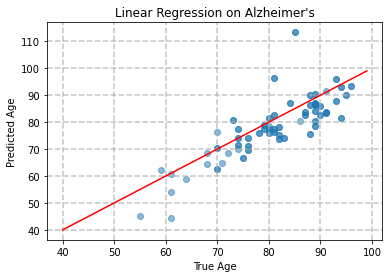

The rms on the Alzheimers data is 6.992 years
The r^2 on the Alzheimers data is 0.381


In [26]:
#model is: mod_56_whole_blood 

# Make predictions and evaluate
preds_alz = mod_56_whole_blood .predict(X_alz)
rms_alz = sqrt(mean_squared_error(y_alz, preds_alz))
r2_alz = r2_score(y_alz, preds_alz)

# Plot 

plt.scatter(y_alz, preds_alz, alpha=0.5)
plt.plot(range(40,100), range(40,100), c='red')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.title("Linear Regression on Alzheimer's")
plt.show()
    
# print metric
print(f'The rms on the Alzheimers data is {rms_alz:.3f} years')
print(f'The r^2 on the Alzheimers data is {r2_alz:.3f}')


### Lasso

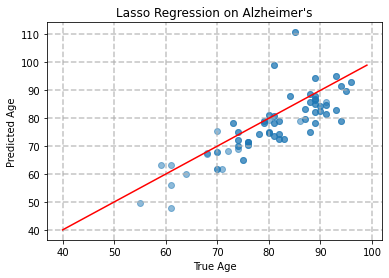

The rms on the Alzheimers data is 7.342 years
The r^2 on the Alzheimers data is 0.317


In [27]:
#model is: mod_lasso_56_whole_blood 

# Make predictions and evaluate
preds_lasso_alz = mod_lasso_56_whole_blood .predict(X_alz)
rms_lasso_alz = sqrt(mean_squared_error(y_alz, preds_lasso_alz))
r2_lasso_alz = r2_score(y_alz, preds_lasso_alz)

# Plot 

plt.scatter(y_alz, preds_lasso_alz, alpha=0.5)
plt.plot(range(40,100), range(40,100), c='red')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.title("Lasso Regression on Alzheimer's")
plt.show()
    
# print metric
print(f'The rms on the Alzheimers data is {rms_lasso_alz:.3f} years')
print(f'The r^2 on the Alzheimers data is {r2_lasso_alz:.3f}')


### Ridge

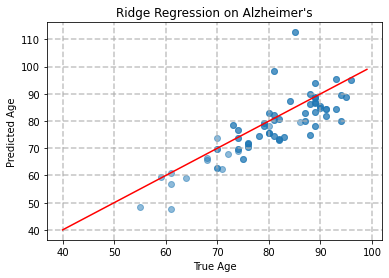

The rms on the Alzheimers data is 7.177 years
The r^2 on the Alzheimers data is 0.347


In [28]:
#model is: mod_ridge_56_whole_blood 

# Make predictions and evaluate
preds_ridge_alz = mod_ridge_56_whole_blood .predict(X_alz)
rms_ridge_alz = sqrt(mean_squared_error(y_alz, preds_ridge_alz))
r2_ridge_alz = r2_score(y_alz, preds_ridge_alz)

# Plot 

plt.scatter(y_alz, preds_ridge_alz, alpha=0.5)
plt.plot(range(40,100), range(40,100), c='red')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.title("Ridge Regression on Alzheimer's")
plt.show()
    
# print metric
print(f'The rms on the Alzheimers data is {rms_ridge_alz:.3f} years')
print(f'The r^2 on the Alzheimers data is {r2_ridge_alz:.3f}')


## Parkinson's 

In [29]:
X_park = mean_impute(parkinsons_df.iloc[:, 1:])
y_park = parkinsons_df[['AGE']].astype(float).astype(int)

### Linear Regression

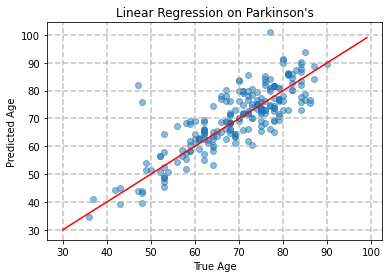

The rms on the Parkinsons data is 6.569 years
The r^2 on the Parkinsons data is 0.617


In [30]:
#model is: mod_56_whole_blood 

# Make predictions and evaluate
preds_park = mod_56_whole_blood .predict(X_park)
rms_park = sqrt(mean_squared_error(y_park, preds_park))
r2_park = r2_score(y_park, preds_park)

# Plot 

plt.scatter(y_park, preds_park, alpha=0.5)
plt.plot(range(30,100), range(30,100), c='red')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.title("Linear Regression on Parkinson's")
plt.show()
    
# print metric
print(f'The rms on the Parkinsons data is {rms_park:.3f} years')
print(f'The r^2 on the Parkinsons data is {r2_park:.3f}')


### Lasso

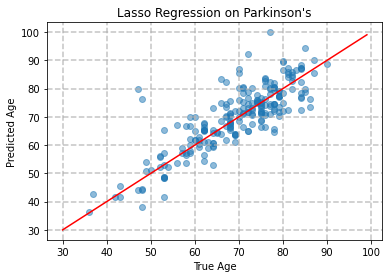

The rms on the Parkinsons data is 6.475 years
The r^2 on the Parkinsons data is 0.628


In [31]:
#model is: mod_lasso_56_whole_blood 

# Make predictions and evaluate
preds_lasso_park = mod_lasso_56_whole_blood .predict(X_park)
rms_lasso_park = sqrt(mean_squared_error(y_park, preds_lasso_park))
r2_lasso_park = r2_score(y_park, preds_lasso_park)

# Plot 

plt.scatter(y_park, preds_lasso_park, alpha=0.5)
plt.plot(range(30,100), range(30,100), c='red')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.title("Lasso Regression on Parkinson's")
plt.show()
    
# print metric
print(f'The rms on the Parkinsons data is {rms_lasso_park:.3f} years')
print(f'The r^2 on the Parkinsons data is {r2_lasso_park:.3f}')


### Ridge

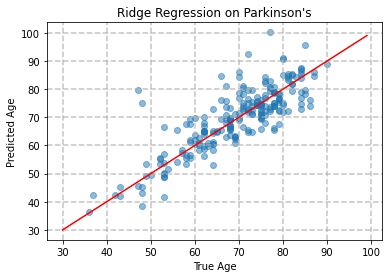

The rms on the Parkinsons data is 6.438 years
The r^2 on the Parkinsons data is 0.633


In [32]:
#model is: mod_ridge_56_whole_blood 

# Make predictions and evaluate
preds_ridge_park = mod_ridge_56_whole_blood .predict(X_park)
rms_ridge_park = sqrt(mean_squared_error(y_park, preds_ridge_park))
r2_ridge_park = r2_score(y_park, preds_ridge_park)

# Plot 

plt.scatter(y_park, preds_ridge_park, alpha=0.5)
plt.plot(range(30,100), range(30,100), c='red')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.title("Ridge Regression on Parkinson's")
plt.show()
    
# print metric
print(f'The rms on the Parkinsons data is {rms_ridge_park:.3f} years')
print(f'The r^2 on the Parkinsons data is {r2_ridge_park:.3f}')


# Saving the non-na data

In [173]:
alzheimers_df.to_csv('alz_56_no_na.csv', encoding='utf-8', index=True)

In [174]:
parkinsons_df.to_csv('park_56_no_na.csv', encoding='utf-8', index=True)

## XGBoost

In [148]:
xgb_order=XG_56_whole_blood.get_booster().feature_names
#ln=['cg23078123', 'cg02933228', 'cg00329615', 'cg25410668', 'cg01256539', 'cg16054275', 'cg07418114', 'cg09692396', 'cg16932827', 'cg03607117', 'cg06977935', 'cg01552919', 'cg07927379', 'cg22285878', 'cg00292135', 'cg18343474', 'cg02046143', 'cg03883331', 'cg22454769', 'cg08453194', 'cg09809672', 'cg24724428', 'cg06540876', 'cg04875128', 'cg22452230', 'cg22193924', 'cg23606718', 'cg06784991', 'cg18933331', 'cg01074797', 'cg25256723', 'cg26614073', 'cg18877361', 'cg03404339', 'cg24079702', 'cg20273670', 'cg23744638', 'cg07955995', 'cg26113593', 'cg12252865', 'cg04503319', 'cg07553761', 'cg16867657', 'cg10221746', 'cg19344626', 'cg14692377', 'cg20532418', 'cg23091758', 'cg05308819', 'cg04573078', 'cg00776080', 'cg07181952', 'cg05093315', 'cg00535618', 'cg04208403', 'cg06639320']
#xgb_order=ln
alzheimers_df_xgb = alzheimers_df[['AGE']+xgb_order]
alzheimers_df_xgb


,AGE,cg16867657,cg04875128,cg07553761,cg00292135,cg09809672,cg04208403,cg22454769,cg06639320,cg19344626,...,cg26614073,cg14692377,cg18343474,cg26113593,cg00535618,cg04503319,cg05308819,cg05093315,cg07181952,cg22193924
GSM1069225,81.0,0.772,0.364,0.391,0.147,0.431,0.545,0.655,0.530,0.631,...,0.436,0.257,0.144,0.755,0.712,0.502,0.491,0.660,0.617,0.830
GSM1069226,88.0,0.778,0.409,0.367,0.158,0.356,0.540,0.705,0.606,0.515,...,0.419,0.193,0.156,0.821,0.717,0.466,0.422,0.590,0.612,0.742
GSM1069227,91.0,0.839,0.429,0.329,0.174,0.414,0.547,0.639,0.538,0.347,...,0.291,0.228,0.154,0.807,0.671,0.537,0.461,0.673,0.635,0.847
GSM1069228,87.0,0.773,0.367,0.343,0.211,0.502,0.547,0.684,0.559,0.713,...,0.482,0.260,0.143,0.813,0.710,0.572,0.484,0.613,0.678,0.814
GSM1069229,89.0,0.822,0.325,0.392,0.144,0.287,0.428,0.667,0.587,0.256,...,0.284,0.227,0.327,0.754,0.738,0.367,0.402,0.481,0.540,0.816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1870611,75.9,0.695,0.139,0.311,0.149,0.337,0.484,0.552,0.513,0.607,...,0.394,0.151,0.140,0.769,0.727,0.556,0.437,0.621,0.610,0.814
GSM3035793,80.0,0.670,0.319,0.350,0.139,0.400,0.535,0.701,0.549,0.592,...,0.409,0.217,0.193,0.706,0.671,0.466,0.443,0.565,0.590,0.700
GSM1870291,75.9,0.695,0.139,0.311,0.149,0.337,0.484,0.552,0.513,0.607,...,0.394,0.151,0.140,0.769,0.727,0.556,0.437,0.621,0.610,0.814
GSM1299778,70.0,0.729,0.233,0.383,0.125,0.356,0.566,0.607,0.527,0.479,...,0.409,0.174,0.099,0.750,0.756,0.530,0.506,0.599,0.671,0.787


In [154]:
X_alz_xgb = alzheimers_df_xgb.iloc[:, 1:].astype(float).to_numpy()
y_alz_xgb = alzheimers_df_xgb[['AGE']].astype(float).astype(int).to_numpy()



#X_alz_xgb.to_csv('alzheimers_df_xgb.csv', encoding='utf-8', index=True)

In [159]:
X_alz_xgb

array([[0.772, 0.364, 0.391, ..., 0.66 , 0.617, 0.83 ],
       [0.778, 0.409, 0.367, ..., 0.59 , 0.612, 0.742],
       [0.839, 0.429, 0.329, ..., 0.673, 0.635, 0.847],
       ...,
       [0.695, 0.139, 0.311, ..., 0.621, 0.61 , 0.814],
       [0.729, 0.233, 0.383, ..., 0.599, 0.671, 0.787],
       [0.813, 0.332, 0.431, ..., 0.656, 0.637, 0.803]])

In [150]:
dtest = xgb.DMatrix('alzheimers_df_xgb.csv?format=csv&label_column=1')

In [156]:
valid = xgb.DMatrix(data=X_alz_xgb,label=y_alz_xgb)

In [165]:
#model is: XG_56_whole_blood

# Make predictions and evaluate
preds_xg_alz = XG_56_whole_blood2.predict(X_alz_xgb)
rms_xg_alz = sqrt(mean_squared_error(y_alz_xgb, preds_xg_alz))
r2_xg_alz = r2_score(y_alz_xgb, preds_xg_alz)

# Plot 

plt.scatter(y_alz_xgb, preds_xg_alz, alpha=0.5)
plt.plot(range(40,100), range(40,100), c='red')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.title("XGBoost on Alzheimer's")
plt.show()
    
# print metric
print(f'The rms on the Alzheimers data is {rms_xg_alz:.3f} years')
print(f'The r^2 on the Alzheimers data is {r2_xg_alz:.3f}')


ValueError: feature_names mismatch: ['cg16867657', 'cg04875128', 'cg07553761', 'cg00292135', 'cg09809672', 'cg04208403', 'cg22454769', 'cg06639320', 'cg19344626', 'cg02046143', 'cg23606718', 'cg08453194', 'cg23744638', 'cg07927379', 'cg24724428', 'cg23078123', 'cg16932827', 'cg10221746', 'cg18877361', 'cg03607117', 'cg09692396', 'cg06784991', 'cg23091758', 'cg02933228', 'cg01552919', 'cg00329615', 'cg03883331', 'cg16054275', 'cg12252865', 'cg22285878', 'cg03404339', 'cg24079702', 'cg20273670', 'cg00776080', 'cg06540876', 'cg25410668', 'cg07955995', 'cg01074797', 'cg22452230', 'cg07418114', 'cg18933331', 'cg01256539', 'cg06977935', 'cg20532418', 'cg04573078', 'cg25256723', 'cg26614073', 'cg14692377', 'cg18343474', 'cg26113593', 'cg00535618', 'cg04503319', 'cg05308819', 'cg05093315', 'cg07181952', 'cg22193924'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55']
expected cg23078123, cg02933228, cg00329615, cg25410668, cg01256539, cg16054275, cg07418114, cg09692396, cg16932827, cg03607117, cg06977935, cg01552919, cg07927379, cg22285878, cg00292135, cg18343474, cg02046143, cg03883331, cg22454769, cg08453194, cg09809672, cg24724428, cg06540876, cg04875128, cg22452230, cg22193924, cg23606718, cg06784991, cg18933331, cg01074797, cg25256723, cg26614073, cg18877361, cg03404339, cg24079702, cg20273670, cg23744638, cg07955995, cg26113593, cg12252865, cg04503319, cg07553761, cg16867657, cg10221746, cg19344626, cg14692377, cg20532418, cg23091758, cg05308819, cg04573078, cg00776080, cg07181952, cg05093315, cg00535618, cg04208403, cg06639320 in input data
training data did not have the following fields: f23, f0, f54, f5, f32, f14, f6, f3, f4, f10, f52, f30, f41, f50, f39, f33, f18, f53, f34, f35, f22, f48, f26, f55, f36, f11, f19, f38, f7, f24, f44, f25, f15, f45, f20, f46, f51, f16, f13, f37, f17, f27, f40, f47, f21, f28, f49, f8, f1, f9, f29, f31, f42, f2, f12, f43

In [137]:
ln=['cg23078123', 'cg02933228', 'cg00329615', 'cg25410668', 'cg01256539', 'cg16054275', 'cg07418114', 'cg09692396', 'cg16932827', 'cg03607117', 'cg06977935', 'cg01552919', 'cg07927379', 'cg22285878', 'cg00292135', 'cg18343474', 'cg02046143', 'cg03883331', 'cg22454769', 'cg08453194', 'cg09809672', 'cg24724428', 'cg06540876', 'cg04875128', 'cg22452230', 'cg22193924', 'cg23606718', 'cg06784991', 'cg18933331', 'cg01074797', 'cg25256723', 'cg26614073', 'cg18877361', 'cg03404339', 'cg24079702', 'cg20273670', 'cg23744638', 'cg07955995', 'cg26113593', 'cg12252865', 'cg04503319', 'cg07553761', 'cg16867657', 'cg10221746', 'cg19344626', 'cg14692377', 'cg20532418', 'cg23091758', 'cg05308819', 'cg04573078', 'cg00776080', 'cg07181952', 'cg05093315', 'cg00535618', 'cg04208403', 'cg06639320']

In [163]:
XG_56_whole_blood.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.7,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}